<a href="https://colab.research.google.com/github/nepalprabin/pytorch/blob/master/CIFAR10_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training a classifier on CIFAR10**

In [0]:
import torch
import torchvision
from torchvision.transforms import transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
trainset = torchvision.datasets.CIFAR10(root='./data',train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=transform,download=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 27504371.81it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


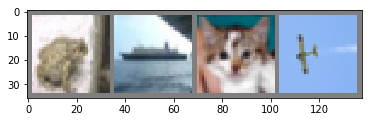

      frog      ship       cat     plane


In [8]:
# Showing some of the training images
import matplotlib.pyplot as plt
import numpy as np

#function to show image
def imshow(img):
  img = img/2+0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#get random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(''.join('%10s' % classes[labels[j]] for j in range(4)))


In [0]:
#Defining a convolutional neural network
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.maxpool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.maxpool1(F.relu(self.conv1(x)))
    x = self.maxpool1(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Network()

In [0]:
#Define Loss function and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
#Training the network
for epoch in range(2):
  running_loss = 0.0
  for i,data in enumerate(trainloader,0):
    inputs, labels = data
    #zero the parameter gradients
    optimizer.zero_grad()

    #forward -> backward -> optimize
    output = net(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    #print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
print("Finished Training")



[1,  2000] loss: 2.215
[1,  4000] loss: 1.826
[1,  6000] loss: 1.651
[1,  8000] loss: 1.577
[1, 10000] loss: 1.539
[1, 12000] loss: 1.467
[2,  2000] loss: 1.417
[2,  4000] loss: 1.363
[2,  6000] loss: 1.365
[2,  8000] loss: 1.293
[2, 10000] loss: 1.304
[2, 12000] loss: 1.281
Finished Training


In [0]:
#Saving our model
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

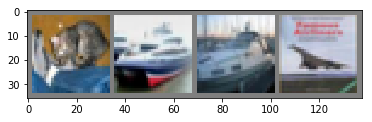

GroundTruth   cat  ship  ship plane


In [18]:
#Testing the network on test data
dataiter = iter(testLoader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
net = Network()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
output = net(images)

In [22]:
_,predicted = torch.max(output,1)
print('Predicted: ',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship truck plane


In [25]:
#Testing the whole dataset
correct = 0
total = 0
with torch.no_grad():
  for data in testLoader:
    images, labels = data
    outputs = net(images)
    _,predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct += (predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 61 %
Accuracy of  bird : 22 %
Accuracy of   cat : 55 %
Accuracy of  deer : 42 %
Accuracy of   dog : 41 %
Accuracy of  frog : 45 %
Accuracy of horse : 78 %
Accuracy of  ship : 56 %
Accuracy of truck : 70 %


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
net.to(device)

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
inputs, labels = data[0].to(device), data[1].to(device)